In [ ]:
!pip install transformers accelerate tdc 

In [6]:
!pip install pytdc
from tdc.single_pred import Tox 
import pandas as pd
import torch

# 1. Load the DILI Dataset - Drug Induced Liver Injury -
# We use the 'Tox' class 
data = Tox(name = 'dili')
split = data.get_split()

print("Training Data Sample:")
print(split['train'].head())

test_df = split['test']
print("\nTest Data Sample:")
print(test_df.head())
!pip uninstall pytdc -y # Delete problematic pytdc package after use - conflict with transformers -

  Using cached pytdc-1.1.15-py3-none-any.whl


Found local copy...
Loading...
Done!


Training Data Sample:
   Drug_ID                                          Drug    Y
0    247.0                         C[N+](C)(C)CC(=O)[O-]  0.0
1    298.0  O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl  0.0
2    338.0                               O=C(O)c1ccccc1O  0.0
3    444.0                CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1  0.0
4    681.0                             NCCc1ccc(O)c(O)c1  0.0

Test Data Sample:
     Drug_ID                                               Drug    Y
0    93860.0     CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O  1.0
1  2723601.0                           Nc1nc(=S)c2[nH]cnc2[nH]1  1.0
2      727.0                       ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl  0.0
3     3033.0                     O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl  1.0
4    60787.0  CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)N...  1.0
Found existing installation: pytdc 1.1.15
Uninstalling pytdc-1.1.15:
  Successfully uninstalled pytdc-1.1.15


In [ ]:
!pip uninstall pytdc -y

In [2]:
# HF Login to access TXGemma
from huggingface_hub import login
login()

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "google/txgemma-2b-predict"

print(f"Loading tokenizer for {model_id}...")

tokenizer = AutoTokenizer.from_pretrained(model_id)

print(f"Loading model: {model_id}. This may take a moment...")

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, # Memory efficient format
    device_map="auto"
)

print("\nModel and tokenizer loaded successfully!")

Loading tokenizer for google/txgemma-2b-predict...
Loading model: google/txgemma-2b-predict. This may take a moment...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]


Model and tokenizer loaded successfully!


In [7]:
# Grab a few examples from the training set to show the model
# One positive (DILI=1) and one negative (DILI=0) example
neg_example = split['train'][split['train']['Y'] == 0].iloc[0]
pos_example = split['train'][split['train']['Y'] == 1].iloc[0]

# Few-shot prompting
# It shows the model exactly what we want.
few_shot_prompt_template = f"""<|begin_of_text|><|start_header_id|>user<|end_header_id|>

I will give you a molecule's SMILES string. You will predict its DILI (Drug-Induced Liver Injury) classification. Output ONLY a 1 for toxic or a 0 for not toxic.

---
EXAMPLE 1
Molecule SMILES: {neg_example['Drug']}
DILI Prediction: {int(neg_example['Y'])}
---
EXAMPLE 2
Molecule SMILES: {pos_example['Drug']}
DILI Prediction: {int(pos_example['Y'])}
---
TASK
Molecule SMILES: {{smiles}}
DILI Prediction:<|eot_id|><|start_header_id|>model<|end_header_id|>
"""

print("--- Few-Shot Prompt Template Created ---")
print(few_shot_prompt_template.format(smiles="[YOUR SMILES HERE]"))

--- Few-Shot Prompt Template Created ---
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

I will give you a molecule's SMILES string. You will predict its DILI (Drug-Induced Liver Injury) classification. Output ONLY a 1 for toxic or a 0 for not toxic.

---
EXAMPLE 1
Molecule SMILES: C[N+](C)(C)CC(=O)[O-]
DILI Prediction: 0
---
EXAMPLE 2
Molecule SMILES: NC(=O)c1cnccn1
DILI Prediction: 1
---
TASK
Molecule SMILES: [YOUR SMILES HERE]
DILI Prediction:<|eot_id|><|start_header_id|>model<|end_header_id|>



In [11]:
import torch
from tqdm.auto import tqdm 
import numpy as np

from transformers import AutoTokenizer, AutoModel

base_model_id = "google/txgemma-2b-predict"
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
model = AutoModel.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

def get_embedding(smiles_string, prompt_template):
    prompt = prompt_template.format(smiles=smiles_string)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state[0, -1, :].cpu().float().numpy()
    return embedding

embedding_prompt_template = "Represent this molecule for DILI prediction: {smiles}"

# --- Generate embeddings for Train and Test sets ---
print("Generating embeddings for the training set...")
X_train = np.array([get_embedding(s, embedding_prompt_template) for s in tqdm(split['train']['Drug'])])
y_train = split['train']['Y'].values

print("\nGenerating embeddings for the test set...")
X_test = np.array([get_embedding(s, embedding_prompt_template) for s in tqdm(split['test']['Drug'])])
y_test = split['test']['Y'].values

print(f"\nCreated training data X_train with shape: {X_train.shape}")
print(f"Created test data X_test with shape: {X_test.shape}")
print("\nEmbedding generation complete!")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Generating embeddings for the training set...


  0%|          | 0/332 [00:00<?, ?it/s]


Generating embeddings for the test set...


  0%|          | 0/95 [00:00<?, ?it/s]


Created training data X_train with shape: (332, 2304)
Created test data X_test with shape: (95, 2304)

Embedding generation complete!



--- Training the Logistic Regression Classifier ---
Training complete.

--- Making Predictions on the Test Set ---

--- Final Model Performance ---

Accuracy: 0.7474
Precision: 0.7500
Recall: 0.7500
F1-Score: 0.7500

--- Generating Confusion Matrix ---


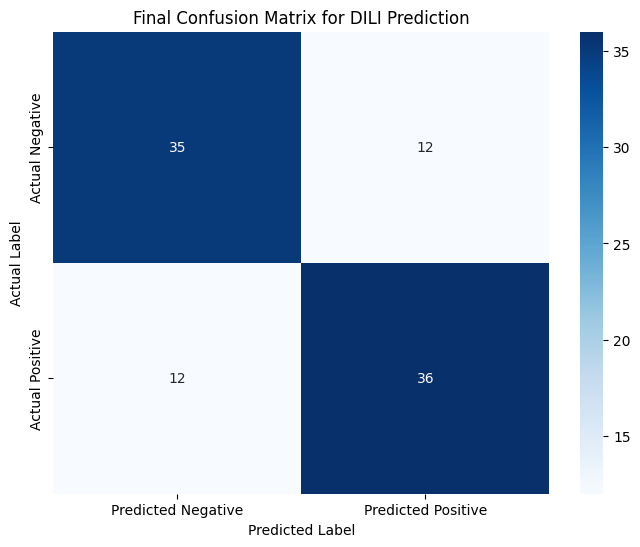

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define and train the classifier
classifier = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')

print("\n--- Training the Logistic Regression Classifier ---")
classifier.fit(X_train, y_train)
print("Training complete.")

# 2. Make predictions on the test set embeddings
print("\n--- Making Predictions on the Test Set ---")
y_pred = classifier.predict(X_test)

# 3. Evaluate the final performance
print("\n--- Final Model Performance ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 4. Visualize the results with a Confusion Matrix
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Final Confusion Matrix for DILI Prediction')
plt.show()

--- Preparing to Visualize Test Set Embeddings ---
t-SNE data already exists. Skipping re-calculation.
Creating plot...


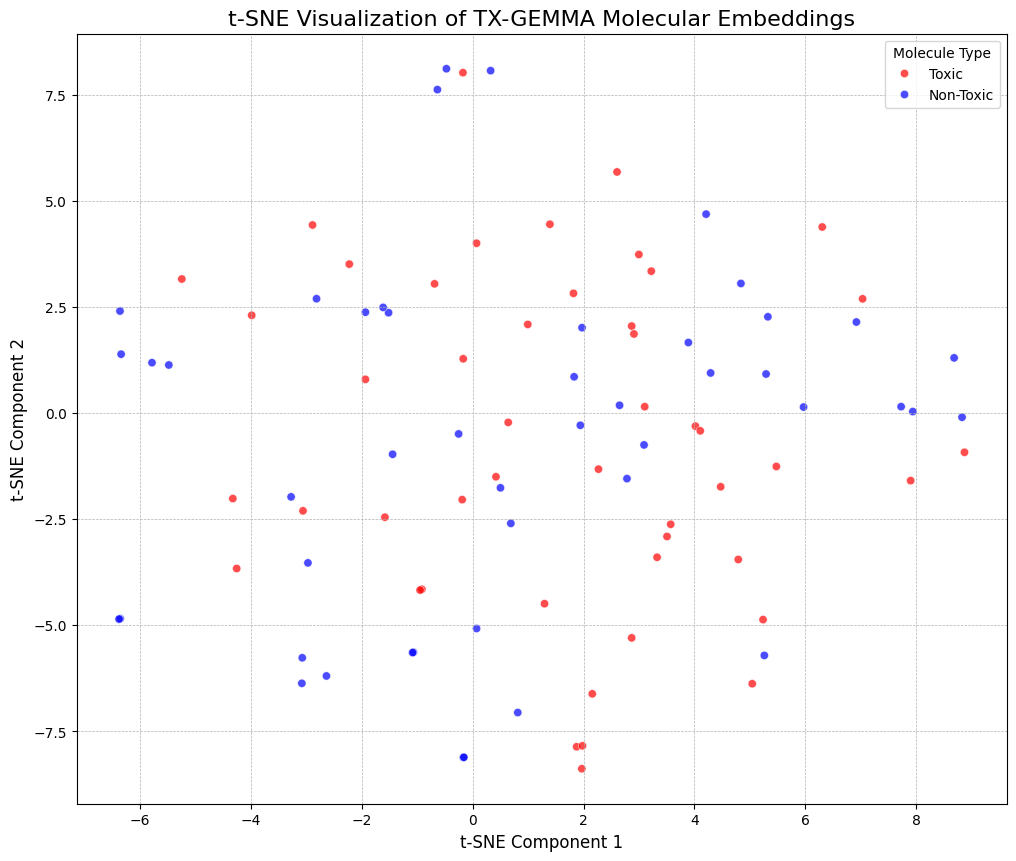

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- Preparing to Visualize Test Set Embeddings ---")

# Check if the 2D data already exists to avoid re-running t-SNE
try:
    X_test_2d.shape
    print("t-SNE data already exists. Skipping re-calculation.")
except NameError:
    print("Running t-SNE... (This may take a moment)")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    X_test_2d = tsne.fit_transform(X_test)
    print("t-SNE complete.")

# Create a DataFrame for easy plotting with Seaborn
vis_df = pd.DataFrame(X_test_2d, columns=['Component 1', 'Component 2'])
vis_df['DILI Label'] = y_test
vis_df['Toxicity'] = vis_df['DILI Label'].map({0: 'Non-Toxic', 1: 'Toxic'})

print("Creating plot...")

# --- Create the plot ---
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x='Component 1', y='Component 2',
    hue='Toxicity',
    palette={"Non-Toxic": "blue", "Toxic": "red"},
    data=vis_df,
    legend='full',
    alpha=0.7
)

plt.title('t-SNE Visualization of TX-GEMMA Molecular Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Molecule Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()